# Creation of a benchmark from a pre-existing set of data

In [1]:
from sys import path
path.insert(0,'../')
import benchmark

## In case the `csv` file is present

In [2]:
from pandas import read_csv
df=read_csv('pvc_benchs.csv',index_col=0)

In [3]:
from os.path import join,dirname
from BigDFT.Logfiles import Logfile as L
lfs={}
for l in df.index:
    lfs.setdefault(dirname(l),[]).append(L(l))

## From the benchmark directories containing the logfiles

In [4]:
from os.path import join
from BigDFT.Logfiles import Logfile as L
#read the results and convert then into dataframes (may take a while)
lfs={join(directory,nds): [L(l) for l in benchmark.extract_results(directory=join(directory,nds))]
     for directory in ['UO2_2-CPU', 'UO2_2-GPU', 'UO2_2-SYCLCPU'] for nds in '1node  2node  4node  8node'.split()}    

In [5]:
lfs

{'UO2_2-CPU/1node': [<BigDFT.Logfiles.Logfile at 0x9a9fb0e39b0>],
 'UO2_2-CPU/2node': [<BigDFT.Logfiles.Logfile at 0x9a9fb2e5070>],
 'UO2_2-CPU/4node': [<BigDFT.Logfiles.Logfile at 0x9a9fa48c500>],
 'UO2_2-CPU/8node': [<BigDFT.Logfiles.Logfile at 0x9a9fa610470>],
 'UO2_2-GPU/1node': [<BigDFT.Logfiles.Logfile at 0x9a9fb0f95b0>],
 'UO2_2-GPU/2node': [<BigDFT.Logfiles.Logfile at 0x9a9faf70410>],
 'UO2_2-GPU/4node': [<BigDFT.Logfiles.Logfile at 0x9a9fa950440>],
 'UO2_2-GPU/8node': [<BigDFT.Logfiles.Logfile at 0x9a9fa7f8170>],
 'UO2_2-SYCLCPU/1node': [<BigDFT.Logfiles.Logfile at 0x9a9fb02c4a0>],
 'UO2_2-SYCLCPU/2node': [<BigDFT.Logfiles.Logfile at 0x9a9fa9881a0>],
 'UO2_2-SYCLCPU/4node': [<BigDFT.Logfiles.Logfile at 0x9a9fa5dc380>],
 'UO2_2-SYCLCPU/8node': [<BigDFT.Logfiles.Logfile at 0x9a9fb0103e0>]}

# Create the dictionaries of the campaigns
We rework in this case the name of the runs, by only including the base dirname:

In [4]:
from os.path import dirname
lfd={}
for k,v in lfs.items():
    lfd.setdefault(dirname(k),[]).extend(v)
run_specs=benchmark.campaign_spec_from_logs(lfd)

We have now obtained three different campaigns, each one with a different runtime.
Such campaigns can then be launched on a remote machine.

In [5]:
run_specs.keys()

dict_keys(['UO2_2-CPU', 'UO2_2-GPU', 'UO2_2-SYCLCPU'])

The `run_specs` dictionary obtained in this way can be employed to rerun the same benchmank on a machine of similar
architecture.

# Running the benchmarks on a different architecture
We can employ those data on another architecture. For instance we can prepare the UO2 benchmark on the aquarius part of the wisteria machine.

We have seen that to run a benchmark we need:

* A `campaign` run specification (we have just extracted three above). For each of these campaigns, we then have to create:

* A `remotemanager.Computer` class instance.

* A `remotemanager.Dataset` class instance to append the runs into.

Let us start by instantiating the `aquarius` Computer class. This information can be found in the computers database.

In [6]:
from BigDFT.Interop import RemoteManagerInterop as RM
from remotemanager import Computer, Dataset
platforms, applications = RM.get_host_specs('wisteria',uri='../computers')
aquarius = Computer(**platforms['gpu'])

Once this class has been instantiated, we may have access to the campaign specifications:

In [7]:
key = 'UO2_2-CPU'
campaign = run_specs[key]

In [8]:
# here the arguments for the instantiation of the dataset
def dataset_args(name, remote_basedir):
    from os.path import join
    return dict(name=name,local_dir=name,
                remote_dir=join(remote_basedir,name),
                dbfile=name+'.yaml')
remote_basedir="/data/scratch/jh210022a/q25020/benchmarks"
ds=Dataset(benchmark.run_bigdft,url=aquarius,**dataset_args(key, remote_basedir),**applications['aquarius'])
ds.wipe_runs()

In [25]:
from importlib import reload
reload(benchmark)

<module 'benchmark' from '/work/execute/bigdft-remote-bench/UO2_2/../benchmark.py'>

In [9]:
run_spec=benchmark.create_bench_spec(df,cores_per_node=36,omps=[1,2,4,9],max_nodes=1,fragment_size=1432,fill_node=False)

In [10]:
run_spec

{'uo2_2': [{'omp': 1, 'mpi': 1, 'name': 'uo2_2-1-1'},
  {'omp': 1, 'mpi': 2, 'name': 'uo2_2-2-1'},
  {'omp': 1, 'mpi': 4, 'name': 'uo2_2-4-1'},
  {'omp': 1, 'mpi': 8, 'name': 'uo2_2-8-1'},
  {'omp': 1, 'mpi': 16, 'name': 'uo2_2-16-1'},
  {'omp': 1, 'mpi': 32, 'name': 'uo2_2-32-1'},
  {'omp': 2, 'mpi': 1, 'name': 'uo2_2-1-2'},
  {'omp': 2, 'mpi': 2, 'name': 'uo2_2-2-2'},
  {'omp': 2, 'mpi': 4, 'name': 'uo2_2-4-2'},
  {'omp': 2, 'mpi': 8, 'name': 'uo2_2-8-2'},
  {'omp': 2, 'mpi': 16, 'name': 'uo2_2-16-2'},
  {'omp': 4, 'mpi': 1, 'name': 'uo2_2-1-4'},
  {'omp': 4, 'mpi': 2, 'name': 'uo2_2-2-4'},
  {'omp': 4, 'mpi': 4, 'name': 'uo2_2-4-4'},
  {'omp': 4, 'mpi': 8, 'name': 'uo2_2-8-4'},
  {'omp': 9, 'mpi': 1, 'name': 'uo2_2-1-9'},
  {'omp': 9, 'mpi': 2, 'name': 'uo2_2-2-9'},
  {'omp': 9, 'mpi': 4, 'name': 'uo2_2-4-9'}]}

We now overwrite the run_spec dictionary of the previous campaign with the present one in order to run the benchmarks

In [11]:
posinp=campaign['run_spec']['uo2_2'][0]['posinp']
for run in run_spec['uo2_2']:
    run.update({'posinp':posinp})

In [12]:
campaign['run_spec']=run_spec

In [13]:
for run in benchmark.campaign(**campaign):
    mpi=run['mpi']
    omp=run['omp']
    cores_per_node = ds.url.cores_per_node.value
    nodes=int((omp*mpi-1)/cores_per_node) +1
    print(mpi,omp,nodes)
    ds.append_run(**run,nodes=nodes)

1 1 1
appended run uo2_2-1-1
2 1 1
appended run uo2_2-2-1
4 1 1
appended run uo2_2-4-1
8 1 1
appended run uo2_2-8-1
16 1 1
appended run uo2_2-16-1
32 1 1
appended run uo2_2-32-1
1 2 1
appended run uo2_2-1-2
2 2 1
appended run uo2_2-2-2
4 2 1
appended run uo2_2-4-2
8 2 1
appended run uo2_2-8-2
16 2 1
appended run uo2_2-16-2
1 4 1
appended run uo2_2-1-4
2 4 1
appended run uo2_2-2-4
4 4 1
appended run uo2_2-4-4
8 4 1
appended run uo2_2-8-4
1 9 1
appended run uo2_2-1-9
2 9 1
appended run uo2_2-2-9
4 9 1
appended run uo2_2-4-9


In [14]:
benchmark.df_select(df,{0:'-CPU'}).Walltime

UO2_2-CPU/1node/log-uo2_2.yaml    8692.166077
UO2_2-CPU/2node/log-uo2_2.yaml    4279.022461
UO2_2-CPU/4node/log-uo2_2.yaml    2178.573071
UO2_2-CPU/8node/log-uo2_2.yaml    1152.512465
Name: Walltime, dtype: float64

In [15]:
ds.run(time=10000)

Running Dataset
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-1-1... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-2-1... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-4-1... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-8-1... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-16-1... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-32-1... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-1-2... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-2-2... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-4-2... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-8-2... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-16-2... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-1-4... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-2-4... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-4-4... running
assessing run for runner UO2_2-CPU-9ebc2ed4-uo2_2-8-4... running
assess

In [38]:
df_cpu=benchmark.dataframe(benchmark.extract_results('UO2_2-CPU'))

Document 0 of stream NOT loaded, error: while parsing a flow node
did not find expected node content
  in "<unicode string>", line 1710, column 1
UO2_2-CPU/log-uo2_2-8-1.yaml No log information provided.
Document 0 of stream NOT loaded, error: while parsing a flow node
did not find expected node content
  in "<unicode string>", line 1709, column 1
UO2_2-CPU/log-uo2_2-4-2.yaml No log information provided.
Document 0 of stream NOT loaded, error: while parsing a flow node
did not find expected node content
  in "<unicode string>", line 1712, column 1
UO2_2-CPU/log-uo2_2-16-2.yaml No log information provided.


## Running another camapign with GPU acceleration
It is also possible to modify the input parameters in order to achieve GPU acceleration
in the `aquarius` platform. In order to do this we need to create another campaign.
Let's perform the same steps as before.

In [16]:
from BigDFT.Inputfiles import Inputfile
key = 'UO2_2-GPU'
campaign = run_specs[key]
inp = Inputfile(campaign['input'])
inp.use_gpu_acceleration() #this activates CUDA acceleration for the psolver part
for run in run_spec['uo2_2']:
    run.update({'posinp':posinp})
campaign['run_spec']=run_spec

The same operation can be performed now

In [17]:
ds=Dataset(benchmark.run_bigdft,url=aquarius,**dataset_args(key, remote_basedir),**applications['aquarius'])
ds.wipe_runs()

In [18]:
for run in benchmark.campaign(**campaign):
    mpi=run['mpi']
    omp=run['omp']
    cores_per_node = ds.url.cores_per_node.value
    nodes=int((omp*mpi-1)/cores_per_node) +1
    print(mpi,omp,nodes)
    ds.append_run(**run,nodes=nodes)

1 1 1
appended run uo2_2-1-1
2 1 1
appended run uo2_2-2-1
4 1 1
appended run uo2_2-4-1
8 1 1
appended run uo2_2-8-1
16 1 1
appended run uo2_2-16-1
32 1 1
appended run uo2_2-32-1
1 2 1
appended run uo2_2-1-2
2 2 1
appended run uo2_2-2-2
4 2 1
appended run uo2_2-4-2
8 2 1
appended run uo2_2-8-2
16 2 1
appended run uo2_2-16-2
1 4 1
appended run uo2_2-1-4
2 4 1
appended run uo2_2-2-4
4 4 1
appended run uo2_2-4-4
8 4 1
appended run uo2_2-8-4
1 9 1
appended run uo2_2-1-9
2 9 1
appended run uo2_2-2-9
4 9 1
appended run uo2_2-4-9


In [19]:
benchmark.df_select(df,{0:'-GPU'}).Walltime

UO2_2-GPU/1node/log-uo2_2.yaml    518.415963
UO2_2-GPU/2node/log-uo2_2.yaml    300.522436
UO2_2-GPU/4node/log-uo2_2.yaml    166.007142
UO2_2-GPU/8node/log-uo2_2.yaml    102.358285
Name: Walltime, dtype: float64

In [20]:
ds.run(time=1000)

Running Dataset
assessing run for runner UO2_2-GPU-65501099-uo2_2-1-1... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-2-1... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-4-1... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-8-1... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-16-1... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-32-1... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-1-2... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-2-2... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-4-2... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-8-2... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-16-2... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-1-4... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-2-4... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-4-4... running
assessing run for runner UO2_2-GPU-65501099-uo2_2-8-4... running
assess

In [24]:
for run, stat in zip(ds.runners,ds.is_finished):
    print(run.name,stat)

uo2_2-1-1 True
uo2_2-2-1 False
uo2_2-4-1 False
uo2_2-8-1 True
uo2_2-16-1 True
uo2_2-32-1 True
uo2_2-1-2 True
uo2_2-2-2 False
uo2_2-4-2 True
uo2_2-8-2 True
uo2_2-16-2 True
uo2_2-1-4 True
uo2_2-2-4 True
uo2_2-4-4 True
uo2_2-8-4 True
uo2_2-1-9 True
uo2_2-2-9 True
uo2_2-4-9 True


In [25]:
ds.fetch_results()

Fetching results
Donesferring 15 Files... 


In [30]:
ds.local_dir

'UO2_2-GPU'

In [39]:
df_gpu=benchmark.dataframe(benchmark.extract_results(ds.local_dir))

Document 0 of stream NOT loaded, error: while parsing a flow node
did not find expected node content
  in "<unicode string>", line 1708, column 1
UO2_2-GPU/log-uo2_2-2-2.yaml No log information provided.
Document 0 of stream NOT loaded, error: while parsing a flow node
did not find expected node content
  in "<unicode string>", line 1708, column 1
UO2_2-GPU/log-uo2_2-2-1.yaml No log information provided.


In [41]:
from pandas import concat
df=concat([df_cpu,df_gpu])

In [99]:
dft=df[['Walltime','timefile','name']].dropna().sort_values('Walltime',ascending=False)

In [100]:
dft

Walltime                          timefile  \
UO2_2-CPU/log-uo2_2-32-1.yaml  9882.511182  UO2_2-CPU/./time-uo2_2-32-1.yaml   
UO2_2-GPU/log-uo2_2-4-2.yaml    819.604999   UO2_2-GPU/./time-uo2_2-4-2.yaml   
UO2_2-GPU/log-uo2_2-8-1.yaml    790.603297   UO2_2-GPU/./time-uo2_2-8-1.yaml   
UO2_2-GPU/log-uo2_2-16-1.yaml   568.359892  UO2_2-GPU/./time-uo2_2-16-1.yaml   
UO2_2-GPU/log-uo2_2-8-2.yaml    512.186939   UO2_2-GPU/./time-uo2_2-8-2.yaml   
UO2_2-GPU/log-uo2_2-32-1.yaml   444.008415  UO2_2-GPU/./time-uo2_2-32-1.yaml   
UO2_2-GPU/log-uo2_2-16-2.yaml   428.827368  UO2_2-GPU/./time-uo2_2-16-2.yaml   

                                     name  
UO2_2-CPU/log-uo2_2-32-1.yaml  uo2_2-32-1  
UO2_2-GPU/log-uo2_2-4-2.yaml    uo2_2-4-2  
UO2_2-GPU/log-uo2_2-8-1.yaml    uo2_2-8-1  
UO2_2-GPU/log-uo2_2-16-1.yaml  uo2_2-16-1  
UO2_2-GPU/log-uo2_2-8-2.yaml    uo2_2-8-2  
UO2_2-GPU/log-uo2_2-32-1.yaml  uo2_2-32-1  
UO2_2-GPU/log-uo2_2-16-2.yaml  uo2_2-16-2

In [101]:
benchmark.lfs_add_files(list(dft.index)+list(dft.timefile))

"UO2_2-CPU/log-uo2_2-32-1.yaml" already supported
"UO2_2-GPU/log-uo2_2-4-2.yaml" already supported
"UO2_2-GPU/log-uo2_2-8-1.yaml" already supported
"UO2_2-GPU/log-uo2_2-16-1.yaml" already supported
"UO2_2-GPU/log-uo2_2-8-2.yaml" already supported
"UO2_2-GPU/log-uo2_2-32-1.yaml" already supported
"UO2_2-GPU/log-uo2_2-16-2.yaml" already supported
"UO2_2-CPU/./time-uo2_2-32-1.yaml" already supported
"UO2_2-GPU/./time-uo2_2-4-2.yaml" already supported
"UO2_2-GPU/./time-uo2_2-8-1.yaml" already supported
"UO2_2-GPU/./time-uo2_2-16-1.yaml" already supported
"UO2_2-GPU/./time-uo2_2-8-2.yaml" already supported
"UO2_2-GPU/./time-uo2_2-32-1.yaml" already supported
"UO2_2-GPU/./time-uo2_2-16-2.yaml" already supported


In [125]:
# from BigDFT.Interop import RemoteManagerInterop as RM
# cp=RM.code_compiler(builddir='/opt/bigdft')
# cp.append_run(action='buildone -f pybigdft')
# cp.run()
# cp.hard_reset()

Warning! The current url is not a subclass of Computer, the dataset may not function as expected.
appended run runner-0
Running Dataset
assessing run for runner compile-c48c306e-runner-0... running
Transferring 3 Files... Done


In [69]:
from importlib import reload
reload(benchmark)

<module 'benchmark' from '/work/execute/bigdft-remote-bench/UO2_2/../benchmark.py'>

In [77]:
rmf=[]
for directory in ['UO2_2-CPU', 'UO2_2-GPU', 'UO2_2-SYCLCPU']:
    rmf += benchmark.get_remotemanager_files(directory=directory)

In [82]:
import os
for r in rmf:
    if os.path.isfile(r):
        os.remove(r)

# Plot the data to be provided

In [104]:
data=benchmark.timefile_data(dft.timefile)

([('BLAS-LAPACK', array([20., 43., 46., 28., 25., 20., 19.])),
  ('Communications', array([393.,  17.,  17.,  28.,  16.,  27.,  23.])),
  ('Convolutions', array([3960.,  255.,  233.,  159.,  152.,  117.,  118.])),
  ('Flib LowLevel', array([260. ,  10. ,   9.1,   5.5,   6.5,   3.8,   4.3])),
  ('Linear Algebra', array([2.9, 8.5, 8.1, 4.4, 4.5, 2.8, 2.9])),
  ('Other', array([ 8.7, 16. , 15. , 11. , 11. ,  8.5,  8.5])),
  ('PS Computation',
   array([0.00313, 0.0163 , 0.0122 , 0.00621, 0.0104 , 0.00324, 0.00786])),
  ('Potential', array([0.2 , 0.29, 0.33, 0.23, 0.18, 0.17, 0.13])),
  ('Unknown', array([0., 0., 0., 0., 0., 0., 0.]))],
 array([4640.,  351.,  329.,  236.,  215.,  178.,  175.]))

Text(0.5, 1.0, 'Run comparison with speedup')

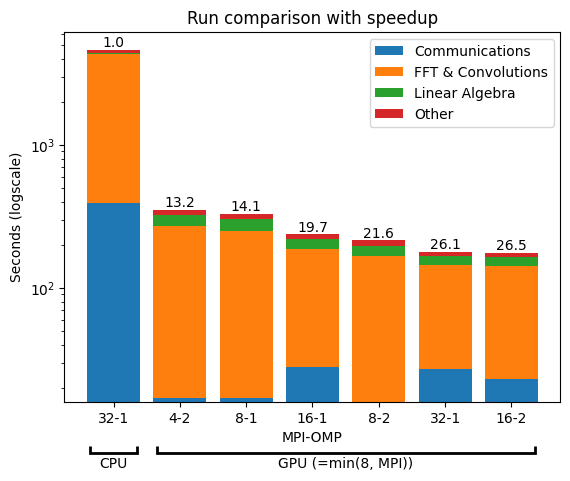

In [123]:
aggregate=[('Communications',['Communications']),
           ('FFT & Convolutions',['Convolutions','PS Computation','Potential']),
           ('Linear Algebra',['BLAS-LAPACK', 'Linear Algebra']),
           ('Other',['Flib LowLevel','Unknown', 'Other'])]
annotations = [round(data[1][0]/d,1) for d in data[1]]
ax=benchmark.draw_barplot([l.lstrip('uo2_-') for l in dft.name],data,aggregate=aggregate,annotations=annotations)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel('MPI-OMP')
ax.set_ylabel('Seconds (logscale)')
ax.legend(loc='best')
spine_pos=-0.14
tip_pos=-0.12
extra_off = 0.35
for start,end,label in [(0,0,'CPU'),
                        (1,6,'GPU (=min(8, MPI))')]:
    benchmark.add_label_band(ax, 'x', start-extra_off, end+extra_off, label,
                   spine_pos=spine_pos,tip_pos=tip_pos)
ax.set_yscale('log')
ax.set_title('Run comparison with speedup')

We see here that the speedup provided by the GPU acceleration on the exac exchange can be evaluated above 25x !